### ToDo

* ...

In [2]:
%%javascript
// keyboard shortcut for running all cells: Ctrl-m + r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from camera_calibration import calibrate_camera, undistort_image
from image_binarization import binarize_frame
from perspective_transformation import get_perspective_transform, warp_image_to_top_down_view
from lane_lines import Line, detect_lane_lines, track_lane_lines, project_lane_lines_to_road, write_curvature_text_to_image, write_lane_offset_text_to_image

def initialize():
    # Calibrate camera
    mtx, dist = calibrate_camera(use_calib_cache=True)
    
    # Perspective transform
    test_image = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)

    img_undistorted = undistort_image(test_image, mtx, dist, plot_images=False)
    
    img_size = (test_image.shape[1], test_image.shape[0])
    perspective_M, perspective_M_inv = get_perspective_transform(img_size)
    
    return mtx, dist, perspective_M, perspective_M_inv

In [4]:
def test_binarize_frame():
    mtx, dist, perspective_M, perspective_M_inv = initialize()

    # Read in an image
    image = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
    img_undistorted = undistort_image(image, mtx, dist, plot_images=False)
    img_binary = binarize_frame(img_undistorted)
    
    img_size = (image.shape[1], image.shape[0])
    top_down_binary = warp_image_to_top_down_view(img_binary.astype(np.uint8), 
                                   img_size, perspective_M).astype(bool)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down_binary, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

# test_binarize_frame()


Using already available cached calibration results.

top_down_binary.shape = (720, 1280)
left_fit: [  5.93193079e-06   2.29126109e-02   2.94748692e+02]
right_fit: [ -4.70246069e-06  -2.74283879e-02   9.98546569e+02]


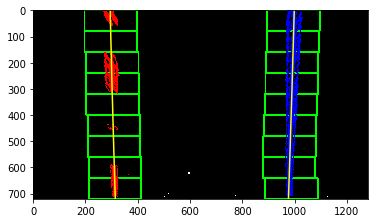

In [5]:
from lane_lines import Line

def test_detect_lane_lines():
    mtx, dist, perspective_M, perspective_M_inv = initialize()    
    line_left = Line()
    line_right = Line()

    # Read in an image
    image = cv2.cvtColor(cv2.imread('./test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
    img_undistorted = undistort_image(image, mtx, dist, plot_images=False)
    img_binary = binarize_frame(img_undistorted)
    
    img_size = (image.shape[1], image.shape[0])
    top_down_binary = warp_image_to_top_down_view(img_binary.astype(np.uint8), 
                                   img_size, perspective_M).astype(bool)
    
    print("top_down_binary.shape = {}".format(top_down_binary.shape))
    out_image = detect_lane_lines(top_down_binary, line_left, line_right, plot_image=True)

    print("left_fit: {}".format(line_left.get_fit()))
    print("right_fit: {}".format(line_right.get_fit()))
    
test_detect_lane_lines()

In [ ]:
# Reset global
num_frames_processed = 0

In [ ]:
### Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video_frame(frame):
    # NOTE: output should be a color image (3 channel) for processing video below    
    global dict_config_params
    global num_frames_processed    
    global mtx, dist, perspective_M, perspective_M_inv
    global left_fit, right_fit, left_fitx, right_fitx
    #global line_left, line_right
    
    frame_undistorted = undistort_image(frame, mtx, dist, plot_images=False)
    frame_binary = binarize_frame(frame_undistorted)
    
    frame_size = (frame_binary.shape[1], frame_binary.shape[0])
    top_down_binary = warp_image_to_top_down_view(frame_binary.astype(np.uint8), 
                                   frame_size, perspective_M).astype(bool)
    
    #print("num_frames_processed: {}".format(num_frames_processed))
    
    out_img = None
    ploty = None
    if num_frames_processed==0:        
        out_img = detect_lane_lines(top_down_binary, 
                                    line_left, line_right, 
                                    plot_image=False)         
    else:        
        out_img = track_lane_lines(top_down_binary, 
                                   line_left, line_right)
    
    num_frames_processed += 1
    #print("num_frames_processed: {}".format(num_frames_processed))
        
    img_lines_on_road = project_lane_lines_to_road(frame_undistorted, out_img,
                                                   line_left, line_right, 
                                                   perspective_M_inv)
    write_curvature_text_to_image(img_lines_on_road, dict_config_params, 
                                  line_left, line_right)
    write_lane_offset_text_to_image(img_lines_on_road, dict_config_params, 
                                  line_left, line_right)
        
    return img_lines_on_road
    
    
# Globals
# Config parameters
dict_config_params = {'x_margin': 100,
                     'y_meter_per_pixel': 30.0/720,
                     'x_meter_per_pixel': 3.7/700,
                     }

left_fit, right_fit, left_fitx, right_fitx = None, None, None, None
mtx, dist, perspective_M, perspective_M_inv = None, None, None, None
line_left = None
line_right = None

if __name__ == '__main__':    
    
    mtx, dist, perspective_M, perspective_M_inv = initialize()
    line_left = Line()
    line_right = Line()
    
    ## secs. 38--43 are difficult
    clip1 = VideoFileClip("./videos/project_video.mp4").subclip(0,2)
    #clip1 = VideoFileClip("project_video.mp4")
    clip = clip1.fl_image(process_video_frame)
    clip.write_videofile("out_project_video.mp4", audio=False)

    # Reset global
    num_frames_processed = 0